## Universidad Autonoma de Aguascalientes
## Departamento: Ciencias de la Computación
## Carrera: Ingeníeria en Computación Inteligente
### Curso: Metaheuristicas I
### Maestro: Dr. Francisco Javier Luna Rosas
### Alumnos: 
### Dante Alejandro Alegria Romero
### Diego Alberto Aranda Gonzalez
### Andrea Margarita Balandran Felix
### Diego Emilia Moreno Sanchez
### Semestre: Agosto_Diciembre del 2024"
### Algoritmo Genetico Binario para Planificar Criticas de Cine

#### Importar Librerias

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd 
from deap import base, creator, tools, algorithms
#import time

#### Cargar datos JSON con los timepos de procesamiento de reseñas de peliculas

In [2]:
with open('reviews.json') as f:
  processing_times = json.load(f)

#### Parametros

In [8]:
num_processors = 8 # numero de procesadores disponibles para la asignacion de tareas
window_size = 100 # tamaño de la slide window (cantidad de reseñas procesadas por cada iteracion)
population_size = 50 # tamaño de la poblacion para el algoritmo genetico
num_generations = 100 # numero de generaciones en el algoritmo genetico
review_counts = [10000, 20000, 30000,
                40000, 50000, 60000,
                70000, 80000, 90000,
                100000] # Lista con la cantidades de reseñas para probar el rendimiento del algoritmo

#### Configuración de DEAP para el algoritmo genetico

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Se crea el tipo de fitness para minimizar el tiempo de procesamiento
creator.create("Individual", list, fitness=creator.FitnessMin) # Se crea el tipo de individuo (soluciones posibles)

#### Inicialización de cada tarea en un individuo como una asignación de procesador (0 a num_processors - 1)

In [6]:
toolbox = base.Toolbox() # Se crea el toolbox para el algoritmo genetico
toolbox.register("attr_processor", random.randint, 0, num_processors - 1) # Procesador aleatorio entre 0 y 7
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_processor, n=window_size) # Crear un individuo con asignaciones aleatorias de procesador para cada tarea
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Crear una población de individuos

def fitness(individual, times):
    #Calcula el tiempo máximo de procesamiento entre todos los procesadores para una asignación dada.
    processor_times = [0] * num_processors  # Inicializa los tiempos de procesamiento para cada procesador
    for task_index, processor in enumerate(individual):
        processor_times[processor] += times[task_index]  # Acumula el tiempo de cada tarea en el procesador asignado
    return max(processor_times),  # Devuelve el tiempo máximo (el objetivo es minimizar este valor)

toolbox.register("evaluate", fitness)  # Registra la función de evaluación en el toolbox
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Cruce uniforme con una probabilidad de 0.5
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # Mutación que invierte el procesador asignado con probabilidad de 0.1
toolbox.register("select", tools.selRoulette)  # Selección de individuos usando ruleta

#### Algoritmo Genetico

In [7]:
def genetic_algorithm(window_times):
    """Ejecuta el algoritmo genético para optimizar la asignación de tareas en una ventana."""
    population = toolbox.population(n=population_size)  # Crea una población inicial
    
    # Define la función de evaluación para esta ejecución
    def evaluate_individual(individual):
        return fitness(individual, window_times)
    
    toolbox.register("evaluate", evaluate_individual)  # Actualiza la función de evaluación en el toolbox
    
    # Calcula la aptitud (fitness) de la población inicial
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
    
    # Ejecuta el algoritmo genético con la función de evaluación actualizada
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)
    
    best_individual = tools.selBest(population, k=1)[0]  # Selecciona el mejor individuo de la población final
    return best_individual, fitness(best_individual, window_times)[0]  # Retorna el mejor individuo y su tiempo óptimo

#### Función para analizar los tiempos de procesamiento

In [11]:
def analyze_processing_times():
    #Compara tiempos de procesamiento secuencial y paralelo optimizado para diferentes cantidades de reseñas.
    sequential_times = []
    parallel_times = []

    for review_count in review_counts:
        # Procesamiento secuencial
        sequential_time = sum(item["time"] for item in processing_times[:review_count])  # Suma de tiempos de procesamiento secuencial
        sequential_times.append(sequential_time)

        # Procesamiento paralelo optimizado con Algoritmo Genético
        total_parallel_time = 0
        for i in range(0, review_count, window_size):
            window_times = [item["time"] for item in processing_times[i:i+window_size]]  # Extrae tiempos de procesamiento en la ventana actual
            _, optimal_time = genetic_algorithm(window_times)  # Ejecuta el algoritmo genético para optimizar la ventana
            total_parallel_time += optimal_time  # Suma el tiempo óptimo de la ventana al tiempo total
        parallel_times.append(total_parallel_time)

        print(f"{review_count} reviews - Sequential: {sequential_time}, Optimized Parallel: {total_parallel_time}")

    return sequential_times, parallel_times

#### Ejecutar el codigo 

In [12]:
sequential_times, parallel_times = analyze_processing_times()

10000 reviews - Sequential: 20.729684591293335, Optimized Parallel: 10.275022983551025
20000 reviews - Sequential: 41.209816455841064, Optimized Parallel: 20.514139890670776
30000 reviews - Sequential: 61.71995258331299, Optimized Parallel: 30.645649671554565
40000 reviews - Sequential: 82.36650466918945, Optimized Parallel: 40.88334083557129
50000 reviews - Sequential: 103.0818510055542, Optimized Parallel: 51.1282172203064
60000 reviews - Sequential: 123.81153559684753, Optimized Parallel: 61.42616152763367
70000 reviews - Sequential: 144.29166746139526, Optimized Parallel: 71.52441453933716
80000 reviews - Sequential: 164.8018035888672, Optimized Parallel: 81.98737812042236
90000 reviews - Sequential: 185.44835567474365, Optimized Parallel: 92.05648255348206
100000 reviews - Sequential: 206.1637020111084, Optimized Parallel: 102.739901304245


#### Graficar resultados del algoritmo 

In [13]:
# Tabla de resultados y porcentajes de mejora
speedup = [sequential / parallel for sequential, parallel in zip(sequential_times, parallel_times)]
percent = [(1 - parallel/sequential) * 100 for sequential, parallel in zip(sequential_times, parallel_times)]

# Dataframe con los resultados de la comparación y el porcentaje de mejora
df = pd.DataFrame({
    'Number of Reviews': review_counts, 
    'Sequential Time': sequential_times, 
    'Parallel Time': parallel_times, 
    'Speedup': speedup, 
    'Improvement (%)': percent
})

df

,Number of Reviews,Sequential Time,Parallel Time,Speedup,Improvement (%)
0,10000,20.729685,10.275023,2.017483,50.433288
1,20000,41.209816,20.514140,2.008849,50.220259
2,30000,61.719953,30.645650,2.013987,50.347257
3,40000,82.366505,40.883341,2.014672,50.364118
4,50000,103.081851,51.128217,2.016144,50.400369
5,60000,123.811536,61.426162,2.015616,50.387368
6,70000,144.291667,71.524415,2.017376,50.430669
7,80000,164.801804,81.987378,2.010087,50.250922
8,90000,185.448356,92.056483,2.014506,50.360044
9,100000,206.163702,102.739901,2.006657,50.165863


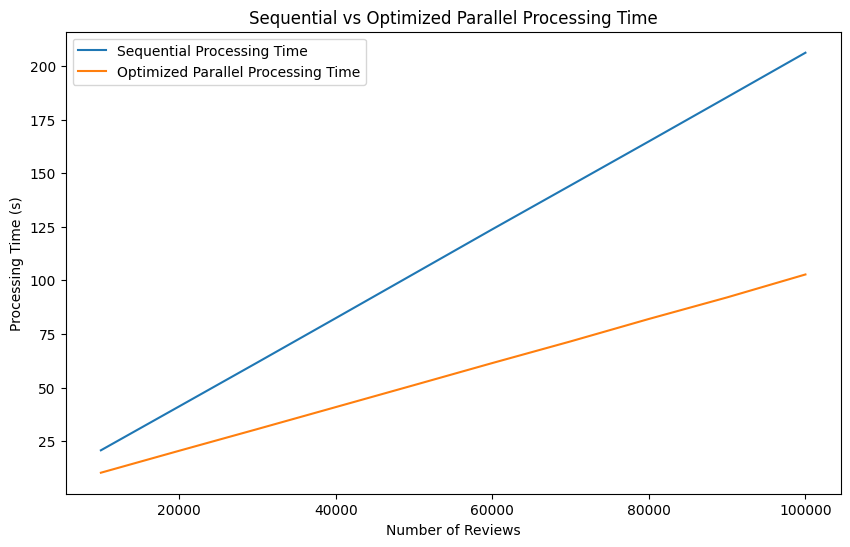

In [14]:
# Gráfico de Resultados
plt.figure(figsize=(10, 6))
plt.plot(review_counts, sequential_times, label='Sequential Processing Time')
plt.plot(review_counts, parallel_times, label='Optimized Parallel Processing Time')
plt.xlabel('Number of Reviews')
plt.ylabel('Processing Time (s)')
plt.title('Sequential vs Optimized Parallel Processing Time')
plt.legend()
plt.show()

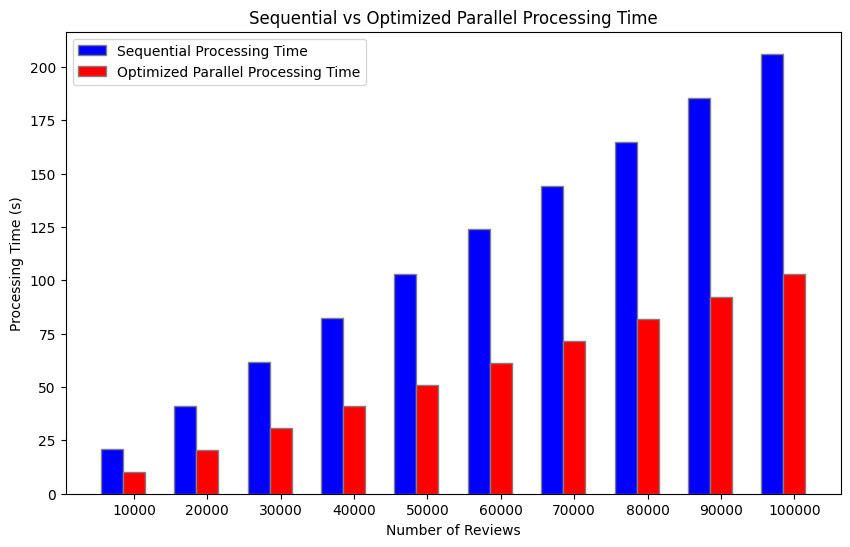

In [15]:
# Gráfico de barras
plt.figure(figsize=(10, 6))
barWidth = 0.3
r1 = np.arange(len(review_counts))
r2 = [x + barWidth for x in r1]
plt.bar(r1, sequential_times, color='b', width=barWidth, edgecolor='grey', label='Sequential Processing Time')
plt.bar(r2, parallel_times, color='r', width=barWidth, edgecolor='grey', label='Optimized Parallel Processing Time')
plt.xlabel('Number of Reviews')
plt.ylabel('Processing Time (s)')
plt.title('Sequential vs Optimized Parallel Processing Time')
plt.xticks([r + barWidth for r in range(len(review_counts))], review_counts)
plt.legend()
plt.show()

#### Conclusiones

##### Este código implementa una comparación entre el procesamiento secuencial y el procesamiento paralelo optimizado mediante un algoritmo genético para la asignación de tareas en un sistema de múltiples procesadores. Se enfoca en mejorar la distribución de tiempos de procesamiento de reseñas de películas, usando un slide window para analizar fragmentos de tareas (reseñas) y distribuirlas eficientemente entre los procesadores.
##### Al aplicar el algoritmo genético, se logra optimizar la asignación de tareas, lo cual reduce significativamente el tiempo total de procesamiento en comparación con el enfoque secuencial. Esta mejora es especialmente notable a medida que aumenta la cantidad de reseñas, demostrando que el algoritmo es eficiente para grandes volúmenes de datos.

#### Referencias

#### DEAP documentation — DEAP 1.4.1 documentation. (s. f.). https://deap.readthedocs.io/en/master/index.html
#### Zomaya, A. Y., & Teh, Y.-H. (2001). Observations on using genetic algorithms for dynamic load-balancing. IEEE Transactions on Parallel and Distributed Systems, 12(9), 899-911.